# 03 - 统计回顾：最危险的公式

在 2007 年的著名文章中，霍华德·韦纳 (Howard Wainer) 针对非常危险的公式做了如下说明[1]：

“有些公式如果你知道它们的话会很危险，而另一些公式如果你不知道它们则会很危险。第一类之所以可能会带来危险，是因为这些公式揭示了通往背后隐藏着的可怕危险。这其中最著名的是爱因斯坦相对论的经典公式：\\( E = mc^2 \\)，因为它揭开了隐藏在普通物质中的巨大能量。... 另一方面，我对那些当我们不知道的时候会带来危险，而当我们明白了道理后反而没有问题的公式更感兴趣。当我们熟悉这些公式的时候，它们能让我们能够清楚地理解事物，但一旦不了解就会让我们处在无知的危险中。”

他所说的就是 Moivre 公式：

$
SE = \dfrac{\sigma}{\sqrt{n}}
$

其中 \\(SE\\) 是平均值的标准误差，\\(\sigma\\) 是标准偏差，\\(n\\) 是样本大小。听起来像一个勇敢而真实的人应该掌握的数学，所以让我们开始认真学习它。

要了解为什么不知道这个等式是非常危险的，让我们来看看一些教育数据。我已经收集了来自不同学校的 ENEM 分数（巴西标准化高中分数，类似于 SAT）的数据，为期 3 年。我还对数据进行了一些清理，只保留与我们相关的信息。原始数据可在[Inep网站](http://portal.inep.gov.br/web/guest/microdados#)下载。

如果我们看看表现最好的学校，就会注意到一些事情：这些学校的学生人数相当少。

In [3]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import style
style.use("fivethirtyeight")

In [4]:
df = pd.read_csv("./data/enem_scores.csv")
df.sort_values(by="avg_score", ascending=False).head(10)

,year,school_id,number_of_students,avg_score
16670,2007,33062633,68,82.97
16796,2007,33065403,172,82.04
16668,2005,33062633,59,81.89
16794,2005,33065403,177,81.66
10043,2007,29342880,43,80.32
18121,2007,33152314,14,79.82
16781,2007,33065250,80,79.67
3026,2007,22025740,144,79.52
14636,2007,31311723,222,79.41
17318,2007,33087679,210,79.38


换个角度看，我们只能把1%的顶尖学校分开来研究。 他们像什么？ 也许我们可以从最好的那里学到一些东西并在其他地方复制它。 果然，如果我们看看排名前 1% 的学校，我们会发现他们的学生平均更少。

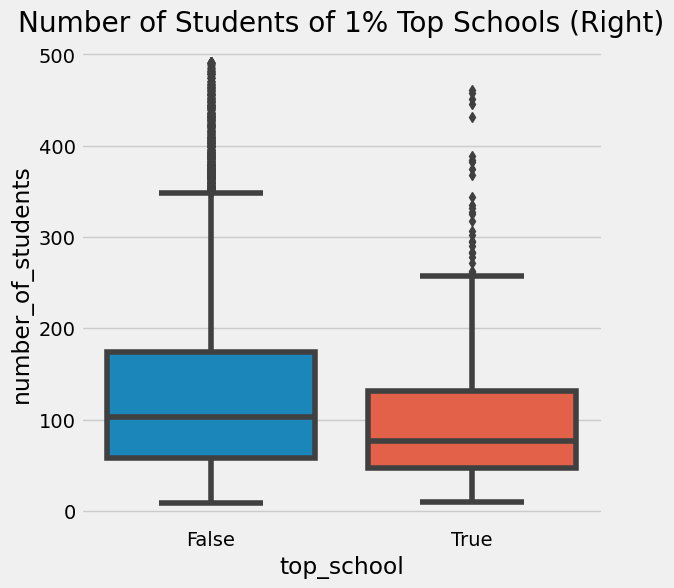

In [5]:
plot_data = (df
             .assign(top_school = df["avg_score"] >= np.quantile(df["avg_score"], .99))
             [["top_school", "number_of_students"]]
             .query(f"number_of_students<{np.quantile(df['number_of_students'], .98)}")) # remove outliers

plt.figure(figsize=(6,6))
sns.boxplot(x="top_school", y="number_of_students", data=plot_data)
plt.title("Number of Students of 1% Top Schools (Right)");

随之而来的一个自然结论是，小班教学会带来更高的学业成绩。 这具有直观的意义，因为我们相信每位教师的学生越少，教师就越可以专注于每个学生。 但这与 Moivre 方程有什么关系呢？ 为什么它是危险的？

好吧，一旦人们开始根据这些信息做出重要且代价高昂的决定，就会变得危险。 在他的文章中，霍华德继续说道：

“在 1990 年代，支持缩小学校规模变得流行起来。许多慈善组织和政府机构根据规模较小的学校的学生在考试成绩高的群体中人数过多的事实，资助了大学校的划分。”

人们忘记做的是还要看看排名垫底的 1% 的学校。 如果我们这样做，瞧！ 他们的学生也很少！

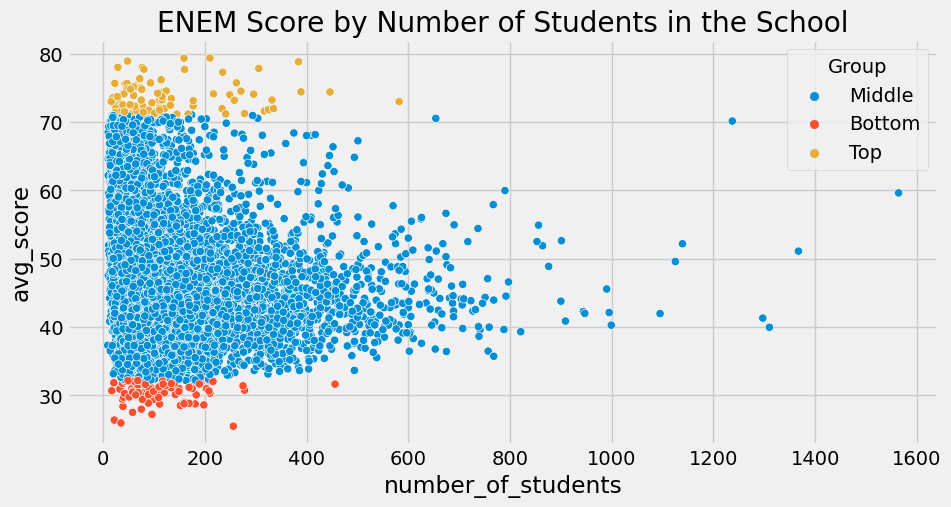

In [6]:
q_99 = np.quantile(df["avg_score"], .99)
q_01 = np.quantile(df["avg_score"], .01)

plot_data = (df
             .sample(10000)
             .assign(Group = lambda d: np.select([d["avg_score"] > q_99, d["avg_score"] < q_01],
                                                 ["Top", "Bottom"], "Middle")))
plt.figure(figsize=(10,5))
sns.scatterplot(y="avg_score", x="number_of_students", hue="Group", data=plot_data)
plt.title("ENEM Score by Number of Students in the School");

我们在上面看到的正是根据 Moivre 方程所预期的。随着学生人数的增加，平均分变得越来越精确。样本很少的学校可能会因为偶然而获得非常高和非常低的分数。大型学校不太可能发生这种情况。 Moivre 的方程谈到了一个现实中关于信息和数据形式记录的基本事实：它总是不精确的。那么问题就变为，到底有多么不精确。

统计学是处理这些不精确性的科学，因此它们不会让我们措手不及。正如塔勒布在他的书《被随机性愚弄》中所说：

> 概率不仅仅是计算骰子或更复杂的变体的几率；它是接受我们的知识缺乏确定性和发展处理我们的无知的方法。

量化我们的不确定性的一种方法是**我们的估计值的方差**。方差告诉我们观察值偏离了它们的中心值和最可能值的程度。正如 Moivre 方程所示，这种不确定性随着我们观察到的数据量的增加而缩小。这是有道理的，对吧？如果我们看到很多学生在学校表现出色，我们就会更有信心这确实是一所好学校。但是，如果我们看到一个只有 10 名学生并且其中 8 名学生表现良好的学校，我们需要多加怀疑。可能是因为偶然，这所学校有一些高于平均水平的学生。

我们上面看到的美丽的三角形图正是讲述了这个故事。它向我们展示了当样本量很小时，我们对学校表现的估计如何存在巨大差异。它还表明方差随着样本量的增加而缩小。这对于学校的平均分数是正确的，但对于我们拥有的任何汇总统计数据也是如此，包括我们经常想要估计的 ATE。

## 我们估计值的标准误差

由于这只是对统计数据的回顾，我现在冒昧地讲得更快一些。如果您不熟悉分布、方差和标准误差，请继续阅读，但请记住，您可能需要一些额外的资源。我建议你用谷歌搜索任何麻省理工学院关于统计介绍的课程。他们通常都很好。

在上一节中，我们将平均处理效果 \\(E[Y_1-Y_0]\\) 估计为处理和未处理之间均值的差异 \\(E[Y|T=1]-E[Y |T=0]\\)。作为我们的示例，我们为在线课程找到了 \\(ATE\\)。我们还看到这是一个负面影响，即在线课程使学生的表现比面对面课程的学生差 5 分左右。现在，我们可以看看这种影响在统计上是否显着。

为此，我们需要估计 \\(SE\\)。我们已经有了 \\(n\\)，我们的样本大小。要获得标准偏差的估计值，我们可以执行以下操作

$
\hat{\sigma}^2=\frac{1}{N-1}\sum_{i=0}^N (x-\bar{x})^2
$

其中 \\(\bar{x}\\) 是 \\(x\\) 的平均值。对我们来说幸运的是，大多数编程软件已经实现了这一点。在 Pandas 中，我们可以使用方法 [std](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.std.html)。

In [7]:
data = pd.read_csv("./data/online_classroom.csv")
online = data.query("format_ol==1")["falsexam"]
face_to_face = data.query("format_ol==0 & format_blended==0")["falsexam"]

def se(y: pd.Series):
    return y.std() / np.sqrt(len(y))

print("SE for Online:", se(online))
print("SE for Face to Face:", se(face_to_face))

SE for Online: 1.5371593973041635
SE for Face to Face: 0.8723511456319104


## 置信区间

我们估计的标准误差是置信度的衡量标准。为了准确理解它的含义，我们需要进入充满争论的统计领域。对于统计学的一种观点，即频率学派的观点，我们会说我们拥有的数据只不过是真实数据生成过程的一种表现。这个过程是抽象的和理想的。它由不变但我们不知道的真实参数控制。在学生测试的背景下，如果我们可以运行多个实验并收集多个数据集，所有这些都将类似于真正的底层数据生成过程，但不会完全如此。这很像柏拉图在形式上的写作：

> 每一种$[$基本形式$]$都表现在各种各样的组合中，有行为，有物质，还有彼此，每一种似乎都有很多  

> Each [of the essential forms] manifests itself in a great variety of combinations, with actions, with material things, and with one another, and each seems to be many  

为了更好地理解这一点，让我们假设我们有一个学生考试成绩的真实抽象分布。这是一个正态分布，真实平均值为 74，真实标准差为 2。从这个分布中，我们可以运行 10000 次实验。在每一个上，我们收集 500 个样本。有些实验数据的平均值会低于真实数据，有些会更高。如果我们将它们绘制在直方图中，我们可以看到实验的均值分布在真实均值附近。

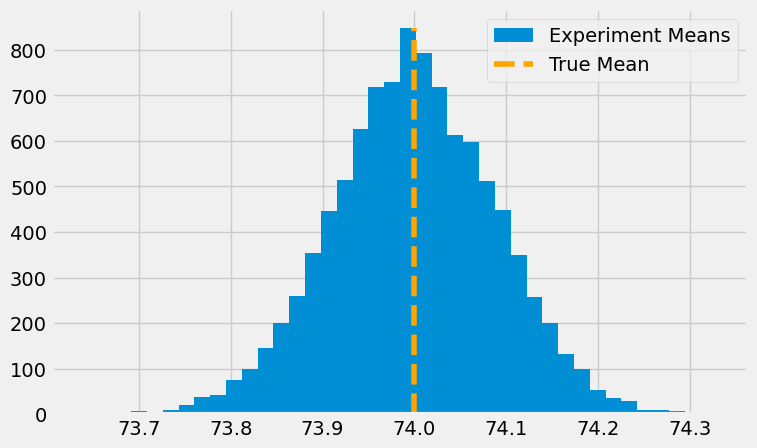

In [8]:
true_std = 2
true_mean = 74

n = 500
def run_experiment(): 
    return np.random.normal(true_mean,true_std, 500)

np.random.seed(42)

plt.figure(figsize=(8,5))
freq, bins, img = plt.hist([run_experiment().mean() for _ in range(10000)], bins=40, label="Experiment Means")
plt.vlines(true_mean, ymin=0, ymax=freq.max(), linestyles="dashed", label="True Mean", color="orange")
plt.legend();

请注意，我们在这里讨论的是均值的均值。因此，假如我们有机会进行一个实验，其中均值可能会略低于或高于真实均值。这就是说，我们永远无法确定实验的均值是否与真正的柏拉图式和理想均值相匹配。但是，**使用标准误差，我们可以创建一个区间，该区间将包含 95% 的时间的真实平均值**。

在现实生活中，我们无法用多个数据集模拟同一个实验。我们经常只有一个。但是我们可以利用上面的直觉来构建我们所说的**置信区间**(**C**onfidence **I**ntervals，CI)。置信区间附带一个概率。最常见的是95%。这个概率告诉我们从不同的研究中建立的假设置信区间有多少包含真实的平均值。例如，从许多类似研究计算的 95% 置信区间将包含 95% 的时间的真实平均值。

为了计算置信区间，我们使用所谓的**中心极限定理**。该定理指出**实验均值是正态分布的**。从统计理论中，我们知道 95% 的正态分布的质量介于均值上下 2 个标准差之间（即3\\( \sigma \\)准则）。从技术上讲，1.96，但 2 已经足够接近了。

![normal_density](./data/img/stats-review/normal_dist.jpeg)

均值的标准误差用作我们对实验均值分布的估计。因此，如果我们将其乘以 2 并从我们的一个实验的平均值中加上和减去它，我们将为真实平均值构建一个 95% 的置信区间。即

In [14]:
np.random.seed(321)
exp_data = run_experiment()
exp_se = exp_data.std() / np.sqrt(len(exp_data)) # 样本标准差
exp_mu = exp_data.mean() # 样本均值
ci = (exp_mu - 2 * exp_se, exp_mu + 2 * exp_se) # 2sigma置信区间
print(ci) 

(73.82718114045632, 74.17341543460314)


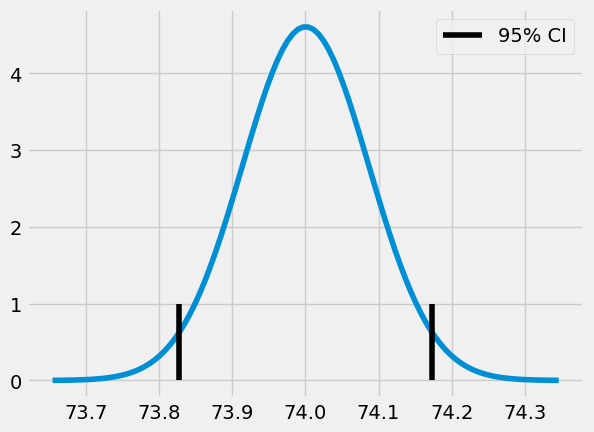

In [15]:
x = np.linspace(exp_mu - 4*exp_se, exp_mu + 4*exp_se, 100)
y = stats.norm.pdf(x, exp_mu, exp_se)

plt.plot(x, y)
plt.vlines(ci[1], ymin=0, ymax=1, color="black")
plt.vlines(ci[0], ymin=0, ymax=1, color="black", label="95% CI")
plt.legend()
plt.show()

当然，我们不需要将自己限制在 95% 的置信区间内。我们可以通过找到一个标准偏差的倍数，使得该区间包含正态分布质量的99%。 

python 中的函数 ppf 为我们提供了 CDF 的倒数。 因此，ppf(0.5) 将返回 0.0，表示标准正态分布质量的 50% 低于 0.0。 同理，如果我们插入 99.5%，我们将得到 z 值，这样 99.5% 的分布质量会低于这个值。 换句话说，质量的 0.05% 落在此值以上。 我们不是像找到 95% CI 那样将标准误差乘以 2，而是将其乘以 z，这将得到 99% CI。

In [11]:
from scipy import stats
z = stats.norm.ppf(.995)
print(z)
ci = (exp_mu - z * exp_se, exp_mu + z * exp_se)
ci

2.5758293035489004


(73.7773381773405, 74.22325839771896)

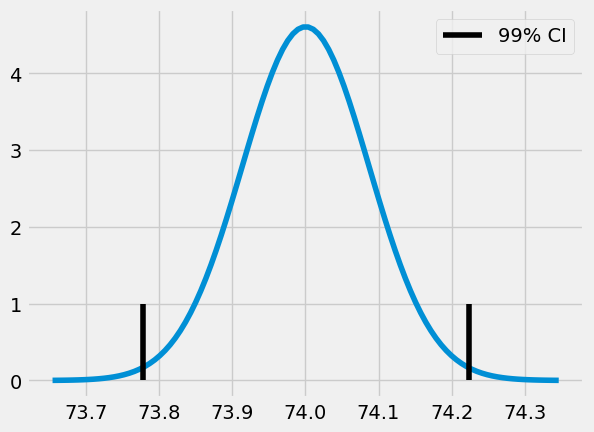

In [13]:
x = np.linspace(exp_mu - 4*exp_se, exp_mu + 4*exp_se, 100)
y = stats.norm.pdf(x, exp_mu, exp_se)
plt.plot(x, y)
plt.vlines(ci[1], ymin=0, ymax=1, color="black")
plt.vlines(ci[0], ymin=0, ymax=1, color="black", label="99% CI")
plt.legend()
plt.show()

回到我们的课堂实验，我们可以为在线和面对面学生组的平均考试分数构建置信区间

In [16]:
def ci(y: pd.Series):
    return (y.mean() - 2 * se(y), y.mean() + 2 * se(y))

print("95% CI for Online:", ci(online))
print("95% CI for Face to Face:", ci(face_to_face))

95% CI for Online: (70.56094429049804, 76.7095818797147)
95% CI for Face to Face: (76.80278229206951, 80.29218687459715)


我们可以看到的是，两组分数的 95% CI 不重叠。面对面课程的 CI 的下端高于在线课程的 CI 的上端。这证明我们的结果并非偶然，面对面课堂学生的真实平均值高于在线课程学生的真实平均值。换句话说，从面对面切换到在线课程时，学习成绩会显著下降。

回顾一下，置信区间是一种为我们的估计设置不确定性的方法。样本量越小，标准误差越大，置信区间越宽。最后，您应该始终对没有附加任何不确定性指标的测量保持怀疑。由于它们非常容易计算，因此缺乏置信区间表示一些不良意图或只是缺乏知识，这同样令人担忧。

![img](data/img/stats-review/ci_xkcd.png)

在此最后提醒一句，置信区间比乍一看更难解释。例如，我**不应该**说这个特定的 95% 置信区间有95%的概率包含真实总体均值。这是因为在使用置信区间的频率主义统计学中，总体均值被视为真实总体常数。因此，它要么在我们特定的置信区间内，要么不在其中。换句话说，我们具体的置信区间要么包含真实均值，概率为100%，而非95%；如果不包含，则概率为0%。相反，在置信区间中，“95%”指代着许多研究中计算出来的这种类型（即以同样方法得到） 的置信区间所覆盖真实平均数目标百分比。“95%”是对用于计算“95％ CI”的算法本身准确性水平（可靠程度） 的自我评估。

现在，话虽如此，作为一名经济学家（统计学家请勿关注），我认为这种纯粹主义并不是很有用。实际上，你会看到人们说特定的置信区间包含真实均值的时间占95%。虽然是错误的，但这并没有太大的害处，因为它仍然对我们估计中存在着明确程度的不确定性。此外，如果我们转向贝叶斯统计，并使用概率区间而不是置信区间，则可以说该区间包含分布平均值95% 的时间。此外，在我的实践中所见到的情况是，在样本量足够大时，贝叶斯概率区间更类似于置信区间而非频率派愿意承认的那样。因此，请放心地说出你对置信区间想要表达什么观点吧。我不介意你是否说它们包含真实均值95％ 的时间，请永远别忘了将其放在您的估算周围；否则您会显得很傻。


## 假设检验

包含不确定性的另一种方法是陈述假设检验：均值差异在统计上与零（或任何其他值）不同吗？为此，我们将回忆起 2 个独立正态分布的和或差也是正态分布。结果均值将是两个分布之间的总和或差，而方差始终是方差之和：

$
N(\mu_1, \sigma_1^2) - N(\mu_2, \sigma_2^2) = N(\mu_1 - \mu_2, \sigma_1^2 + \sigma_2^2)
$

$
N(\mu_1, \sigma_1^2) + N(\mu_2, \sigma_2^2) = N(\mu_1 + \mu_2, \sigma_1^2 + \sigma_2^2)
$

如果你不记得，没关系。我们可以随时使用代码和模拟数据来检查：

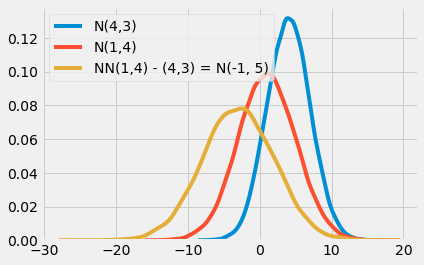

In [13]:
np.random.seed(123)
n1 = np.random.normal(4, 3, 30000)
n2 = np.random.normal(1, 4, 30000)
n_diff = n2 - n1
sns.distplot(n1, hist=False, label="N(4,3)")
sns.distplot(n2, hist=False, label="N(1,4)")
sns.distplot(n_diff, hist=False, label=f"NN(1,4) - (4,3) = N(-1, 5)")
plt.legend()
plt.show()

如果我们取两组均值的分布并从另一个中减去一个，我们将得到第三个分布。 该最终分布的均值将是均值的差值，该分布的标准差将是标准差总和的平方根。

$
\mu_{diff} = \mu_1 - \mu_2
$

$
SE_{diff} = \sqrt{SE_1 + SE_2} = \sqrt{\sigma_1^2/n_1 + \sigma_2^2/n_2}
$

让我们回到我们的课堂例子。 我们将构建这种差异分布。 当然，一旦我们有了它，构建 95% CI 就非常容易了。

In [14]:
diff_mu = online.mean() - face_to_face.mean()
diff_se = np.sqrt(face_to_face.var()/len(face_to_face) + online.var()/len(online))
ci = (diff_mu - 1.96*diff_se, diff_mu + 1.96*diff_se)
print(ci)

(-8.376410208363357, -1.4480327880904964)


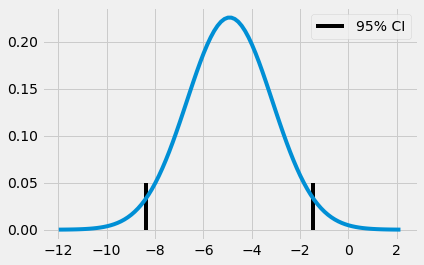

In [15]:
x = np.linspace(diff_mu - 4*diff_se, diff_mu + 4*diff_se, 100)
y = stats.norm.pdf(x, diff_mu, diff_se)
plt.plot(x, y)
plt.vlines(ci[1], ymin=0, ymax=.05)
plt.vlines(ci[0], ymin=0, ymax=.05, label="95% CI")
plt.legend()
plt.show()

有了这个，我们可以说我们有 95% 的信心确定在线课程组和面对面教学组之间的真正差异介于 -8.37 和 -1.44 之间。我们还可以通过将均值差异除以差异的 \\(SE\\) 来构建 **z 统计量**。

$
z = \dfrac{\mu_{diff} - H_{0}}{SE_{diff}} = \dfrac{(\mu_1 - \mu_2) - H_{0}}{\sqrt{\sigma_1^2/n_1 + \sigma_2^2/n_2}}
$

其中 \\(H_0\\) 是我们要测试差异的值。

z 统计量衡量观察到的差异的极端程度。为了检验均值差异在统计上不同于零的假设，我们将使用矛盾。我们将假设相反的情况是正确的，即我们将假设差异为零。这称为零假设，或 \\(H_0\\)。然后，我们会问自己“如果真正的差异确实为零，我们是否可能会观察到这种差异？”在统计数学术语中，我们可以将这个问题转化为检查 z 统计量离零有多远。

在 \\(H_0\\) 下，z 统计量遵循标准正态分布。因此，如果差异确实为零，我们将在 95% 的时间内看到 z 统计量在平均值的 2 个标准差内。这样做的直接后果是，如果 z 高于或低于 2 个标准差，我们可以以 95% 的置信度拒绝原假设。

让我们看看这在我们的课堂示例中是什么样子的。

In [16]:
z = diff_mu / diff_se
print(z)

-2.7792810791031064


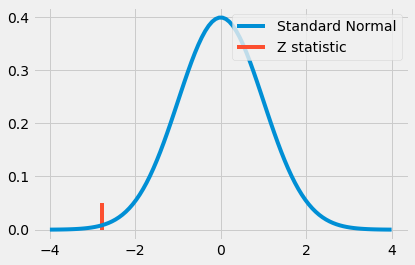

In [17]:
x = np.linspace(-4,4,100)
y = stats.norm.pdf(x, 0, 1)
plt.plot(x, y, label="Standard Normal")
plt.vlines(z, ymin=0, ymax=.05, label="Z statistic", color="C1")
plt.legend()
plt.show()

这看起来是一个非常极端的值。 事实上，它高于 2，这意味着如果组中没有差异，我们看到这样一个极值的可能性不到 5%。 这再次使我们得出结论，从面对面转向在线课程会导致学业成绩在统计上显着下降。

关于假设检验的最后一件有趣的事情是，它不如检查干预组和对照组的 95% CI 是否重叠那么保守。 换句话说，如果两组中的置信区间重叠，仍然可能出现结果具有统计显着性的情况。 例如，假设面对面组的平均分数为 80，标准误差为 4，在线组的平均分数为 71，标准误差为 2。

In [18]:
cont_mu, cont_se =  (71, 2)
test_mu, test_se = (80, 4)

diff_mu = test_mu - cont_mu
diff_se = np.sqrt(cont_se**2 + test_se**2)

print("Control 95% CI:", (cont_mu-1.96*cont_se, cont_mu+1.96*cont_se))
print("Test 95% CI:", (test_mu-1.96*test_se, test_mu+1.96*test_se))
print("Diff 95% CI:", (diff_mu-1.96*diff_se, diff_mu+1.96*diff_se))

Control 95% CI: (67.08, 74.92)
Test 95% CI: (72.16, 87.84)
Diff 95% CI: (0.23461352820082482, 17.765386471799175)


如果我们为这些组构建置信区间，它们就会重叠。在线组 95% CI 的上限为 74.92，面对面组的下限为 72.16。然而，一旦我们计算了组间差异的 95% 置信区间，我们可以看到它不包含零。总之，即使各个置信区间重叠，差异仍然可以在统计上不同于零。

## P 值

我之前说过，如果在线组和面对面组之间的差异实际上为零，我们观察到这种极端值的可能性不到 5%。但是我们能准确估计这个机会是多少吗？我们观察到这样一个极值的可能性有多大？输入 p 值！

就像置信区间（以及大多数频率统计，事实上）一样，p 值的真正定义可能非常令人困惑。因此，为了不冒任何风险，我将复制维基百科的定义：“p 值是获得测试结果的概率至少与测试期间实际观察到的结果一样极端，假设原假设是正确的” .

更简洁地说，p 值是看到此类数据的概率，前提是原假设为真。如果原假设为真，它衡量您看到测量结果的可能性有多大。自然地，这常常与原假设为真的概率混淆。注意这里的区别。 p 值不是 \\(P(H_0|data)\\)，而是 \\(P(data|H_0)\\)。

但是不要让这种复杂性欺骗了您。实际上，它们使用起来非常简单。

![p_value](./data/img/stats-review/p_value.png)

要获得 p 值，我们需要计算 z 统计量之前或之后的标准正态分布下的面积。幸运的是，我们有一台计算机可以帮我们做这个计算。我们可以简单地将 z 统计量插入标准正态分布的 CDF 中。

In [19]:
print("P-value:", stats.norm.cdf(z))

P-value: 0.0027239680835564706


这意味着如果差异为零，则只有 0.2% 的机会观察到这个极端的 z 统计量。 请注意 p 值的有趣之处，因为它避免了我们必须指定置信水平，例如 95% 或 99%。 但是，如果我们希望报告一个，根据 p 值，我们确切地知道我们的测试将通过或失败的置信度。 例如，p 值为 0.0027，我们知道我们在 0.2% 的水平上具有显着性。 因此，虽然差异的 95% CI 和 99% CI 都不包含零，但 99.9% CI 会。

In [20]:
diff_mu = online.mean() - face_to_face.mean()
diff_se = np.sqrt(face_to_face.var()/len(face_to_face) + online.var()/len(online))
print("95% CI:", (diff_mu - stats.norm.ppf(.975)*diff_se, diff_mu + stats.norm.ppf(.975)*diff_se))
print("99% CI:", (diff_mu - stats.norm.ppf(.995)*diff_se, diff_mu + stats.norm.ppf(.995)*diff_se))
print("99.9% CI:", (diff_mu - stats.norm.ppf(.9995)*diff_se, diff_mu + stats.norm.ppf(.9995)*diff_se))

95% CI: (-8.37634655308288, -1.4480964433709733)
99% CI: (-9.464853535264012, -0.3595894611898425)
99.9% CI: (-10.72804065824553, 0.9035976617916743)


## 关键思想

我们已经看到了解 Moivre 方程的重要性，我们用它来确定我们的估计值。 也就是说，我们发现与面对面课程相比，在线课程会导致学习成绩下降。 我们还看到这是一个具有统计意义的结果。 我们通过比较两组均值的置信区间、查看差异的置信区间、进行假设检验和查看 p 值来做到这一点。 下面，让我们将所有内容都包含在一个函数中，该函数通过A/B实验进行比较，就像我们上面所做的那样。

In [21]:
def AB_test(test: pd.Series, control: pd.Series, confidence=0.95, h0=0):
    mu1, mu2 = test.mean(), control.mean()
    se1, se2 = test.std() / np.sqrt(len(test)), control.std() / np.sqrt(len(control))
    
    diff = mu1 - mu2
    se_diff = np.sqrt(test.var()/len(test) + control.var()/len(control))
    
    z_stats = (diff-h0)/se_diff
    p_value = stats.norm.cdf(z_stats)
    
    def critial(se): return -se*stats.norm.ppf((1 - confidence)/2)
    
    print(f"Test {confidence*100}% CI: {mu1} +- {critial(se1)}")
    print(f"Control {confidence*100}% CI: {mu2} +- {critial(se2)}")
    print(f"Test-Control {confidence*100}% CI: {diff} +- {critial(se_diff)}")
    print(f"Z Statistic {z_stats}")
    print(f"P-Value {p_value}")
        
AB_test(online, face_to_face)

Test 95.0% CI: 73.63526308510637 +- 3.0127770572134565
Control 95.0% CI: 78.5474845833333 +- 1.7097768273108005
Test-Control 95.0% CI: -4.912221498226927 +- 3.4641250548559537
Z Statistic -2.7792810791031064
P-Value 0.0027239680835564706


由于我们的函数足够通用，我们可以测试其他零假设。 例如，我们是否可以尝试拒绝在线课堂和面对面课堂表现之间的差异为 -1。 根据我们得到的结果，我们可以 95% 的置信度说差异大于 -1。 但我们在99% 的置信度上却没法这么肯定：

In [22]:
AB_test(online, face_to_face, h0=-1)

Test 95.0% CI: 73.63526308510637 +- 3.0127770572134565
Control 95.0% CI: 78.5474845833333 +- 1.7097768273108005
Test-Control 95.0% CI: -4.912221498226927 +- 3.4641250548559537
Z Statistic -2.2134920404560723
P-Value 0.013431870694630667


## 参考资料

1. https://www.americanscientist.org/article/the-most-dangerous-equation